## Model 
* Neural Network

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,LayerNormalization,Normalization
from tensorflow.keras import utils as np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend as K

sns.set_style('whitegrid') # set style for visualization
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/features_engineered.csv', encoding='utf-8')
df

,SUBJECT_ID,SESSION_ID,TRIAL_ID,c_ml_min_r,c_ml_max_r,c_ml_min_l,c_ml_max_l,c_ap_slope_r,c_ap_slope_l,g_ml_max1_r,...,g_ap_max_l,g_v_max1_r,g_v_min_r,g_v_max2_r,g_v_max1_l,g_v_min_l,g_v_max2_l,AGE,BMI,CLASS_LABEL
0,510,413,1,0.087271,0.118247,0.087814,0.128115,0.001718,0.002493,0.072643,...,0.130772,1.035925,0.818121,0.987930,1.083287,0.796622,1.003385,47,35.538442,C
1,510,413,2,0.085806,0.128396,0.040212,0.083074,0.001589,0.001834,0.072360,...,0.136687,1.009803,0.819649,0.991990,1.018526,0.837006,0.999401,47,35.538442,C
2,510,413,3,0.073788,0.112735,0.049990,0.099952,0.001740,0.001734,0.059417,...,0.143187,1.010970,0.823223,0.989883,1.049092,0.815221,1.003578,47,35.538442,C
3,510,413,4,0.056216,0.102832,0.086729,0.127982,0.001919,0.001361,0.079792,...,0.155758,1.047625,0.797822,1.005463,1.118118,0.773203,1.021851,47,35.538442,C
4,510,413,6,0.064922,0.102404,0.000573,0.052266,0.001837,0.002049,0.059537,...,0.140561,1.044787,0.780821,1.009273,1.084354,0.820851,1.027245,47,35.538442,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75727,93,999910375,6,0.057389,0.081491,-0.007720,-0.005253,0.001445,0.000769,0.027693,...,0.296245,1.227360,0.635865,1.188197,1.210305,0.600266,0.862586,53,21.588183,HC
75728,93,999910375,7,0.060523,0.065029,0.077223,0.107414,0.001117,0.001277,0.069434,...,0.313936,1.360617,0.653168,1.074324,1.195931,0.691509,1.105625,53,21.588183,HC
75729,93,999910375,9,0.068348,0.103938,0.014182,0.031058,0.001457,0.001514,0.042854,...,0.317704,1.220940,0.697688,1.129716,1.132665,0.683090,1.187864,53,21.588183,HC
75730,93,999910375,10,0.032184,0.046935,-0.001137,0.021139,0.001090,0.001431,0.048381,...,0.310775,1.221073,0.704733,1.160231,1.155511,0.767917,1.133180,53,21.588183,HC


In [3]:
df.isna().sum().loc[lambda x : x>0].sort_values(ascending=False)

BMI    26992
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.shape

(48740, 28)

In [6]:
df.columns

Index(['SUBJECT_ID', 'SESSION_ID', 'TRIAL_ID', 'c_ml_min_r', 'c_ml_max_r',
       'c_ml_min_l', 'c_ml_max_l', 'c_ap_slope_r', 'c_ap_slope_l',
       'g_ml_max1_r', 'g_ml_min_r', 'g_ml_max2_r', 'g_ml_max1_l', 'g_ml_min_l',
       'g_ml_max2_l', 'g_ap_min_r', 'g_ap_max_r', 'g_ap_min_l', 'g_ap_max_l',
       'g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l', 'AGE', 'BMI', 'CLASS_LABEL'],
      dtype='object')

### Neural Network using 23 engineered features

In [7]:
# https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html
# https://stackoverflow.com/questions/36232334/plotting-3d-decision-boundary-from-linear-svm

In [8]:
df['CLASS_LABEL'].factorize()

(array([0, 0, 0, ..., 4, 4, 4], dtype=int64),
 Index(['C', 'K', 'H', 'A', 'HC'], dtype='object'))

In [9]:
df['CLASS_LABEL'].factorize()[0]

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [10]:
#prepare the data
X= df[['c_ml_min_r', 'c_ml_max_r',
       'c_ml_min_l', 'c_ml_max_l', 'c_ap_slope_r', 'c_ap_slope_l',
       'g_ml_max1_r', 'g_ml_min_r', 'g_ml_max2_r', 'g_ml_max1_l', 'g_ml_min_l',
       'g_ml_max2_l', 'g_ap_min_r', 'g_ap_max_r', 'g_ap_min_l', 'g_ap_max_l',
       'g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l','AGE','BMI']]
y = np_utils.to_categorical(df['CLASS_LABEL'].factorize()[0])
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [12]:
X_train.shape[1]

24

Explanation for Keras API used: https://keras.io/api/layers
* Model : Sequential
* Pre-processing layer: Normalization
* Core layer: Dense, Relu activation
* Regularisation layer: Dropout?
* Activation layer: Dense, Softmax activation

In [13]:
#create normalisation layer and set initial state using training data
normalization_layer = Normalization()
normalization_layer.adapt(X_train)

#Dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

#Add layers to sequential model
model = Sequential()
model.add(normalization_layer)
model.add(Dense(input_dim, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))
model.compile(optimizer='adam', metrics=['acc'], loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense (Dense)               (None, 24)                600       
                                                                 
 dense_1 (Dense)             (None, 5)                 125       
                                                                 
Total params: 774
Trainable params: 725
Non-trainable params: 49
_________________________________________________________________


In [14]:
%%time
# Fit the model and save into history
history = model.fit(X_train, y_train, batch_size=100, epochs=20, validation_data=(X_test, y_test),verbose=0)

CPU times: total: 13.7 s
Wall time: 42.1 s


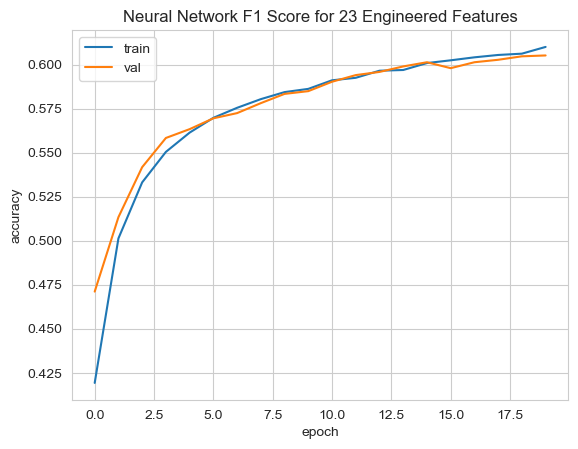

In [15]:
#plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Neural Network F1 Score for 23 Engineered Features')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
#Predict
pred_labels = np.argmax(model.predict(X_test),axis=1)
pred_labels

381/381 [==============================] - 1s 3ms/step


array([3, 3, 4, ..., 1, 4, 3], dtype=int64)

In [17]:
y_test_labels=np.argmax(y_test,axis=1)
y_test_labels

array([0, 3, 4, ..., 1, 0, 3], dtype=int64)

In [18]:
accuracy_score(y_test_labels,pred_labels)

0.6051702913418137

In [19]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test_labels, pred_labels)
print(cm)

[[1094  117   49  598   46]
 [  51 1676  282  634  201]
 [  36  466  724  260  149]
 [ 415  546  192 2535  175]
 [  11  298  121  164 1345]]


In [20]:
def confusion_matrix_metrics(cls, cm):
    TP = cm[cls, cls]
    FN = cm[cls].sum() - TP
    FP = cm[:, cls].sum() - TP
    TN = cm.sum() - TP - FN - FP
    return np.array([[TP, FN], [FP, TN]])

In [21]:
for cls in range(cm.shape[0]):
    print(f'[Class {cls} vs others]')
    TP, FN, FP, TN = confusion_matrix_metrics(cls, cm).ravel()
    print(f'TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}')

[Class 0 vs others]
TP: 1094, FN: 810, FP: 513, TN: 9768
[Class 1 vs others]
TP: 1676, FN: 1168, FP: 1427, TN: 7914
[Class 2 vs others]
TP: 724, FN: 911, FP: 644, TN: 9906
[Class 3 vs others]
TP: 2535, FN: 1328, FP: 1656, TN: 6666
[Class 4 vs others]
TP: 1345, FN: 594, FP: 571, TN: 9675


In [22]:
print(classification_report(y_test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      1904
           1       0.54      0.59      0.56      2844
           2       0.53      0.44      0.48      1635
           3       0.60      0.66      0.63      3863
           4       0.70      0.69      0.70      1939

    accuracy                           0.61     12185
   macro avg       0.61      0.59      0.60     12185
weighted avg       0.61      0.61      0.60     12185



**Findings**
* A, C, H, HC, K
* macro avg is the average of the precision / recall for all classes
* For prediction, we aim to reduce false nagative to capture all walking issues, hence recall is chaosen to be more important metric
* Support is the number of actual occurrences of the class in the specified dataset, the class distribution is not too imbalanced towards class 1 and 3

## Neural Network using original 1000 features

In [23]:
df2 = pd.read_csv('../data/original_features.csv', encoding='utf-8')
df2

,SUBJECT_ID,SESSION_ID,TRIAL_ID,0_cmlr,1_cmlr,2_cmlr,3_cmlr,4_cmlr,5_cmlr,6_cmlr,...,94_gvl,95_gvl,96_gvl,97_gvl,98_gvl,99_gvl,AGE,BMI,SPEED,CLASS_LABEL
0,510,413,1,0.090489,0.088296,0.090543,0.088585,0.088419,0.087271,0.087643,...,0.206161,0.157969,0.114536,0.078322,0.051086,0.030038,47,35.538442,2,C
1,510,413,2,0.099445,0.085806,0.092521,0.089278,0.092119,0.090495,0.091194,...,0.193967,0.150712,0.109526,0.073994,0.048843,0.028040,47,35.538442,2,C
2,510,413,3,0.080434,0.073788,0.076158,0.074499,0.074923,0.074800,0.075813,...,0.207438,0.159884,0.116295,0.077046,0.050402,0.028532,47,35.538442,2,C
3,510,413,4,0.072603,0.056216,0.062936,0.058685,0.061489,0.060092,0.061455,...,0.200746,0.153727,0.111913,0.075615,0.050814,0.029449,47,35.538442,2,C
4,510,413,6,0.076400,0.064922,0.069484,0.067106,0.067142,0.065643,0.066555,...,0.226931,0.175726,0.127687,0.084625,0.054879,0.030352,47,35.538442,2,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75727,93,999910375,6,0.079767,0.063966,0.057389,0.070820,0.062624,0.066724,0.066109,...,0.585992,0.506672,0.378240,0.271666,0.131318,0.068635,53,21.588183,3,HC
75728,93,999910375,7,0.071751,0.068806,0.060523,0.067541,0.065756,0.068228,0.068960,...,0.210229,0.135406,0.074887,0.079133,0.040195,0.060160,53,21.588183,3,HC
75729,93,999910375,9,0.090892,0.075870,0.068348,0.082233,0.079673,0.079846,0.083529,...,0.245192,0.146890,0.067128,0.066237,0.035762,0.058333,53,21.588183,3,HC
75730,93,999910375,10,0.042685,0.034425,0.034721,0.032184,0.037931,0.036505,0.039742,...,0.199702,0.131545,0.081470,0.075674,0.053003,0.048931,53,21.588183,3,HC


In [24]:
df2.dropna(inplace=True)

In [25]:
df2.isna().sum().loc[lambda x : x>0].sort_values(ascending=False)

Series([], dtype: int64)

In [26]:
#prepare the data
X= df2.drop(['SUBJECT_ID','SESSION_ID','TRIAL_ID','SPEED','CLASS_LABEL'],axis=1)
y= np_utils.to_categorical(df2['CLASS_LABEL'].factorize()[0])
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [28]:
X_train.shape

(36555, 1002)

In [29]:
#create normalisation layer and set initial state using training data
normalization_layer = Normalization()
normalization_layer.adapt(X_train)

#Dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

#Add layers to sequential model
model2 = Sequential()
model2.add(normalization_layer)
model2.add(Dense(input_dim, activation='relu'))
model.add(Dropout(.5))
model2.add(Dense(output_dim, activation='softmax'))
model2.compile(optimizer='adam', metrics=['acc'], loss='categorical_crossentropy')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1002)             2005      
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 1002)              1005006   
                                                                 
 dense_3 (Dense)             (None, 5)                 5015      
                                                                 
Total params: 1,012,026
Trainable params: 1,010,021
Non-trainable params: 2,005
_________________________________________________________________


In [30]:
%%time
# Fit the model and save into history
history2 = model2.fit(X_train, y_train, batch_size=100, epochs=20, validation_data=(X_test, y_test),verbose=0)

CPU times: total: 2min 11s
Wall time: 2min 54s


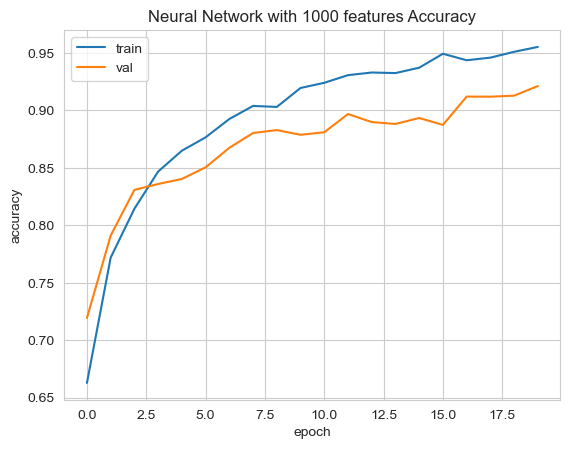

In [31]:
#plot
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Neural Network with 1000 features Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
#Predict
pred_labels = np.argmax(model2.predict(X_test),axis=1)
pred_labels

381/381 [==============================] - 3s 8ms/step


array([0, 3, 4, ..., 1, 0, 3], dtype=int64)

In [33]:
y_test_labels=np.argmax(y_test,axis=1)
y_test_labels

array([0, 3, 4, ..., 1, 0, 3], dtype=int64)

In [34]:
accuracy_score(y_test_labels,pred_labels)

0.9211325400082068

In [35]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test_labels, pred_labels)
print(cm)

[[1793   15    8   82    6]
 [  19 2610   61  109   45]
 [  14   74 1449   68   30]
 [  73  106   59 3565   60]
 [   8   53   14   57 1807]]


In [36]:
for cls in range(cm.shape[0]):
    print(f'[Class {cls} vs others]')
    TP, FN, FP, TN = confusion_matrix_metrics(cls, cm).ravel()
    print(f'TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}')

[Class 0 vs others]
TP: 1793, FN: 111, FP: 114, TN: 10167
[Class 1 vs others]
TP: 2610, FN: 234, FP: 248, TN: 9093
[Class 2 vs others]
TP: 1449, FN: 186, FP: 142, TN: 10408
[Class 3 vs others]
TP: 3565, FN: 298, FP: 316, TN: 8006
[Class 4 vs others]
TP: 1807, FN: 132, FP: 141, TN: 10105


In [37]:
print(classification_report(y_test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1904
           1       0.91      0.92      0.92      2844
           2       0.91      0.89      0.90      1635
           3       0.92      0.92      0.92      3863
           4       0.93      0.93      0.93      1939

    accuracy                           0.92     12185
   macro avg       0.92      0.92      0.92     12185
weighted avg       0.92      0.92      0.92     12185

